# Sentiment Analysis on Lyrics

This blog post is lyrics. About sentiment analysis on lyrics.

**Sentiment Analysis** is one of the techniques of NLP (Natural Language Processing). It is part of NLU (Natural Language Understanding). It allows us to classify the sentiment of a text, positive or negative, according to the words it contains.

This blog post has three parts. The first part is about **Data Collection**. Web scraping using the **`BeautifulSoup`** and **`urllib2`** libraries. The second part, is **Text Analysis**, we use the **`NLTK`** Python library to compute some statistics of the lyrics of the selected artist. And in the third part, is about **Sentiment Analysis**, we use the **[`VADER`](https://github.com/cjhutto/vaderSentiment)** library (yes, Vader as in Star Wars). We will use plot the number of positive and negative songs there is per album. 

Once we collect the discography of the artist we can plot it in [Wordle](http://www.wordle.net), there is a button to do that, but you have to have Java installed.

You can learn more about NLP with these articles [NLP with NLTK Part 1](https://opendatascience.com/blog/nlp-with-nltk-part-1/) and [the second part](https://opendatascience.com/blog/nlp-with-nltk-part-2/). Also I can recommend you this article if you want to [hack your music preferences](https://opendatascience.com/blog/hacking-my-pandora-data-with-unsupervised-learning/) with song's features. In this blog post we will only use lyrics (text).

You can reuse the functions from this code to develop further this article or to create your own projects.

In [1]:
from bs4 import BeautifulSoup
import urllib2 
import re 
import pandas as pd 
from IPython.core.display import display, HTML 
from wordcloud import WordCloud # to plot wordclouds 
import matplotlib.pyplot as plt 

# this line indicates the graphs are displayed in the notebook and not in a new window
%matplotlib inline

## 1. Data Collection

We will use http://lyrics.wikia.com because it has a simple html code to parse and has a vast number of lyrics in their database. Also, it has not limits on requests.

The main function for data collection is **`get_lyrics()`**. It takes an artist name, and downloads its discography. I recommend you to play with its parameters because you can see the cover of the album and wordclouds when you are aquiring the lyrics, just change the binary parameters.

The function **`plot_word_cloud()`** is used to plot wordclouds of the arguments passed.

In [2]:
prefix = 'http://lyrics.wikia.com'

def plot_word_cloud(corpus, max_words = 42, width=600, height=400, fig_size=(8,6)):
    try:
        if len(corpus) == 0:
            corpus = 'no words'
        wordcloud = WordCloud(max_words = max_words, width=width, height=height, background_color="black").generate(corpus)
        plt.figure(figsize=fig_size, dpi=80)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        return
    except:
        pass
    return
    
def get_lyrics(band_name = None
               , display_cover=False
               , show_song_word_cloud=False
               , show_album_word_cloud=False
               , verbose=False):
    """
    Asks for the artists name and download all its lyrics.
    """
    def get_artist_link():
        """
        Asks for a term to search and returns the first result.
        """
        url_search = 'http://lyrics.wikia.com/wiki/Special:Search?query='
        
        if band_name == None:
            site = urllib2.urlopen(url_search + raw_input("Artist's name ?: ").replace(' ', '+')).read()
        else:
            site = urllib2.urlopen(url_search + band_name.replace(' ', '+')).read()
        soup = BeautifulSoup(site)

        links = []
        for link in soup.find_all("a", class_='result-link'):
            if link.get('href') <> None:
                links.append(link.get('href'))
                
        print 'Getting lyrics from...', links[0]
        return links[0]
    
    def display_thumbnail(soup):
        images = soup.find_all("img", class_='thumbborder ')
        for image in images:
            display(HTML(str(image)))
        return
    
    def get_album_links(artist_link):
        link_discs = []
        site = urllib2.urlopen(artist_link).read()
        soup = BeautifulSoup(site)

        discs = soup.find_all("span", class_="mw-headline")
        for d in discs:
            for element in d.find_all('a'):
                link_discs.append(prefix + element.get('href'))

        return link_discs
    
    def get_text(lyric):
        text = ''
        for line in lyric:
            text += line
            
        print camel_case_split(text)
        return camel_case_split(text)
    
    def get_lyrics(url):
        try:
            site = urllib2.urlopen(url).read()
            soup = BeautifulSoup(site)
            lyric = soup.find_all("div", class_="lyricbox")

            if len(lyric) > 0:
                for element in lyric:
                    return re.sub("([a-z])([A-Z])","\g<1> \g<2>", BeautifulSoup(str(element).replace('<br/>',' ')).get_text())
        except:
            pass
        
    def get_list_of_links(url, link_filter):
        links = []
        site = urllib2.urlopen(url).read()
        soup = BeautifulSoup(site)
        
        if (display_cover):
            display_thumbnail(soup)   # displays the albums image

        for link in soup.find_all("a"):
            if link.get('href') <> None and '/wiki/' + link_filter + ':' in link.get('href') and not '?' in link.get('href'):
                links.append(prefix + link.get('href'))

        return links
    
    def download_lyrics(album_links):
        lyrics = []  # list with all the lrrics
        songs = []   # list with scanned links
        discography = []
        i = 1
        
        for album_link in album_links:
            album = []
            print 'Downloading:', i, 'out of', len(album_links), 'albums -', album_link.split(':')[-1].replace('_', ' ')
            i+=1
            for link in get_list_of_links(album_link, link_filter):
                if get_lyrics(link) <> None  and link not in songs:
                    lyrics.append(get_lyrics(link))
                    lyric = get_lyrics(link)
                    
                    album.append(lyric)
                    
                    if verbose:
                        print link.split(':')[-1].replace('_',' ') #print song title
                    if (show_song_word_cloud):
                        plot_word_cloud(lyric.lower(), max_words=50, width=400, height=200)
                    songs.append(link)

            if show_album_word_cloud:
                plot_word_cloud(str(album[:]).lower(), max_words=50, width=800, height=500)
            discography.append((album_link.split(':')[-1].replace('_', ' '), album))

        print '\nDone!', len(songs), 'lyrics aquired from', len(album_links), 'albums.'
        
        return discography
    
    
        
    artist_link = get_artist_link()
    link_filter = artist_link.split('/')[-1]
    album_links = get_album_links(artist_link)
    lyrics = download_lyrics(album_links)
    
    return lyrics

## Demo

I'll use Metallica's lyrics for demonstration because I love MetallicA, you can try with your favorite band. 

### Arguments of `get_lyrics()`

The arguments of the function are the followings:
- `band_name='metallica'` : A `string` to avoid to manually input the name of an artist.
- `display_cover = False` : `Boolean` variable to display the 
- `verbose = False` : `Boolean` variable to show the name of the song that is been processed.
- `show_album_word_cloud = False` : `Boolean` variable to show a word-cloud with the tokens of the album.
- `show_song_word_cloud = False` : `Boolean`
 variable to show a word-cloud with the tokens of the discography at the end of the processing.

In [3]:
corpus = get_lyrics(display_cover = False # displays the cover of the album while is been proceesed
                    #, band_name='metallica' # name of the artist
                    , verbose = False # print the song titles
                    , show_album_word_cloud = False # shows a word-cloud per album
                    , show_song_word_cloud = False) # shows a word-cloud per song

# raw will contains all the text of the lyrics.
raw = ''
for title, songs in corpus:
    for song in songs:
        raw+=song

Artist's name ?: metallica
Getting lyrics from... http://lyrics.wikia.com/wiki/Metallica
Downloading: 1 out of 14 albums - Kill %27Em All (1983)
Downloading: 2 out of 14 albums - Ride The Lightning (1984)
Downloading: 3 out of 14 albums - Master Of Puppets (1986)
Downloading: 4 out of 14 albums - ...And Justice For All (1988)
Downloading: 5 out of 14 albums - Metallica (1991)
Downloading: 6 out of 14 albums -  Binge %26 Purge (1993)
Downloading: 7 out of 14 albums - Load (1996)
Downloading: 8 out of 14 albums - ReLoad (1997)
Downloading: 9 out of 14 albums - Garage Inc. (1998)
Downloading: 10 out of 14 albums - S%26M (1999)
Downloading: 11 out of 14 albums - St. Anger (2003)
Downloading: 12 out of 14 albums - Death Magnetic (2008)
Downloading: 13 out of 14 albums - Lulu (2011)
Downloading: 14 out of 14 albums - Hardwired...To Self-Destruct (2016)

Done! 156 lyrics aquired from 14 albums.


## Wordle

[Wordle](http://www.wordle.net) is a widely known service to plot wordclouds. We can send all the words in the discography to Wordle a get a wordcloud of our artist. Instrctions to do that are here: [advanced instructions](http://www.wordle.net/advanced).

Just click on the **`Get Wordle`** button and you can plot the discography in Wordle. You will need Java.

In [4]:
from IPython.core.display import display, HTML

html_code = """
<form action="http://www.wordle.net/advanced" method="POST" target="_blank">
    <textarea name="text" style="display:none">
        %s
    </textarea>
    <input type="submit" value="Get Wordle">
</form>""" % (raw.lower())

display(HTML(html_code))

## 2. Text Analysis with NLTK

We will use tokenization and word frequency are well explained in the post. I will use them to analyse the content of the lyrics of an artist. 

There are many uses for text analysis. It is usually used to analyse  social networks like Twitter. But you can analyse the content of books, or enterprise data like emails or free text in forms, etc.

We plot the words per album.

In [5]:
import nltk
from __future__ import division
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'

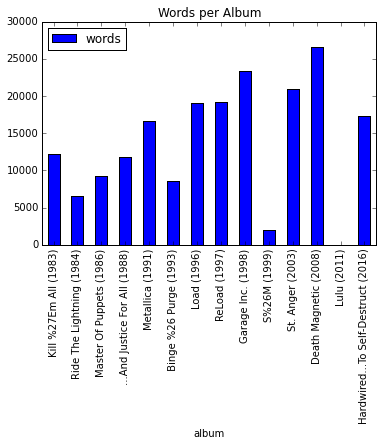

In [6]:
# A plot of how many words per album chronologically and without repetition of the songs.
df1 = pd.DataFrame(columns=('album', 'songs', 'words'))
i = 0
for album_title, songs in corpus:
    words = 0
    for song in songs:
        #print len(song)
        words += len(song)
    df1.loc[i] = (album_title, len(songs), words)
    i += 1

df1.plot.bar(x='album', y='words', title='Words per Album');

In [7]:
tokenizer = RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(raw.lower())   # tokens without punctuation
text = nltk.Text(tokens)

words = [w.lower() for w in tokens]
vocab = sorted(set(words))

filtered_words = [word for word in words if word not in stopwords.words('english') and len(word) > 1 and word not in ['na','la']] # remove the stopwords
fdist = nltk.FreqDist(filtered_words)

### Lexical Dispersion Plot
The Lexical Dispersion Plot shows the most common words along the text. The x-axis is the total number of words in order of appearence, so we can see how they appear in the discography. You can use as many words you want.

### Frequency plot
This is another way of plotting the most used words of the discography.

### Wordcloud
Using the [`wordcloud`](https://github.com/amueller/word_cloud) Python library created by Andreas Mueller, we can plot the most used words of the discography. You can read a Q&A interview to Andreas [here](https://opendatascience.com/blog/interview-with-andreas-mueller/).

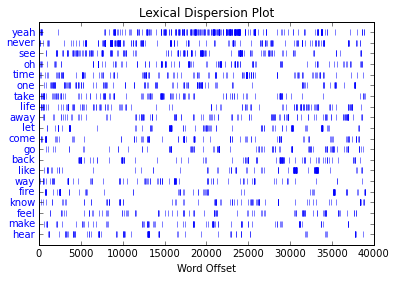

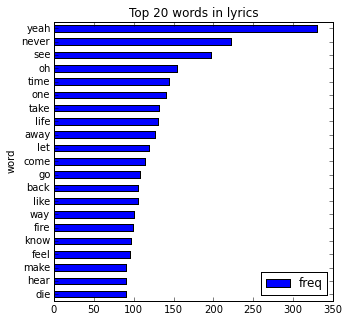

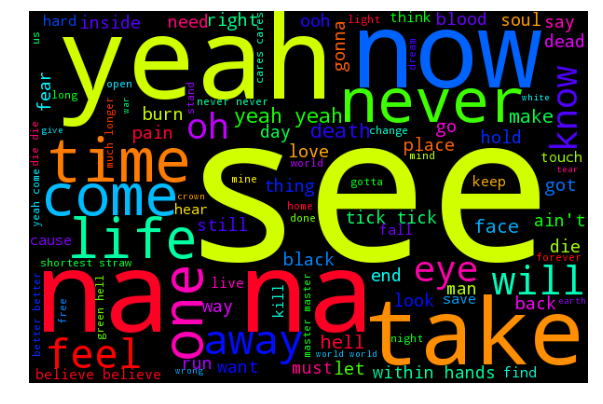

In [8]:
def plot_freq_words(fdist):
    df = pd.DataFrame(columns=('word', 'freq'))
    i = 0
    for word, frequency in fdist.most_common(21):
        df.loc[i] = (word, frequency)
        i += 1

    title = 'Top %s words in lyrics' % top_n
    df.plot.barh(x='word', y='freq', title=title, figsize=(5,5)).invert_yaxis()
    
    return
    
top_n = 20
text.dispersion_plot([str(w) for w, f in fdist.most_common(top_n)])
plot_freq_words(fdist)
plot_word_cloud(raw.lower(), max_words=100, fig_size=(10,8))

# 3. Sentiment Analysis

Finally, we will classify the sentiment of each song as positive, negative or neutral with the [VADER](https://github.com/cjhutto/vaderSentiment) (Valence Aware Dictionary and sEntiment Reasoner) Sentiment-Analysis library, that can be used for longer text than tweets in social networks.

The VADER library gives four scores `compound`, `neg`, `neu`, and `pos`. For this post I'm using the **`compound`** score based on this rules according to the authors.

Vader compound score:
1. **positive sentiment**: `compound` score >= 0.5
2. **neutral sentiment**: (`compound` score > -0.5) and (`compound` score < 0.5)
3. **negative sentiment**: `compound` score <= -0.5

Each song is classified as positive, negative or neutral. Albums are plotted It is plotted how many of each class there is per album and the albums are ordered over time, so we can see an evolution.

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/Users/darenasc/Anaconda/anaconda/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


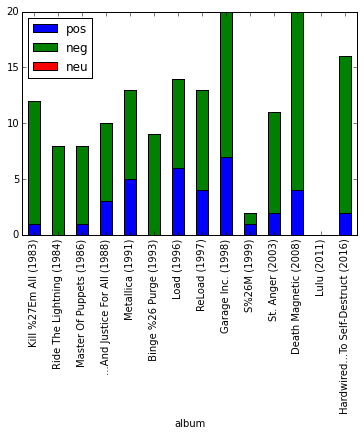

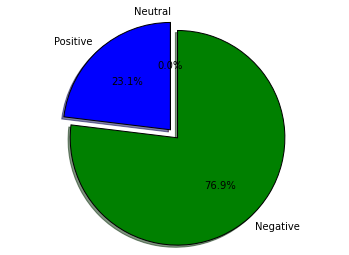

In [10]:
sid = SentimentIntensityAnalyzer()

df = pd.DataFrame(columns=('album', 'pos', 'neg', 'neu'))
df2 = pd.DataFrame(columns=('album', 'pos', 'neg', 'neu'))
i = 0
tot_pos = 0
tot_neg = 0
tot_neu = 0
for album_title, songs in corpus:
    pos = 0
    neg = 0
    neu = 0
    #print album_title
    for song in songs:
        ss = sid.polarity_scores(song)
        if ss['compound'] >= 0.5:
            pos+=1
            tot_pos+=1
        elif ss['compound'] <= 0.5:
            neg+=1
            tot_neg+=1
        else:
            neu+=1
            tot_neu+=1
    df.loc[i] = (album_title, pos, neg, neu)
    if (pos+neg+neu) > 0:
        df2.loc[i] = (album_title, pos / (pos+neg+neu), neg / (pos+neg+neu), neu / (pos+neg+neu))
    i += 1
    
df.plot.bar(x='album',stacked=True);

#print tot_pos, tot_neg, tot_neu, tot_pos / (tot_pos+tot_neg+tot_neu), tot_neg / (tot_pos+tot_neg+tot_neu), tot_neu / (tot_pos+tot_neg+tot_neu)

labels = 'Positive', 'Negative', 'Neutral'
sizes = [tot_pos, tot_neg, tot_neu]
explode = (0, 0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Thanks!

We can see that 23% of Metallica's lyrics have a positive sentiment on it.

I hope you enjoyed getting the sentiment of the lyrics of your favorite artists. Feel free to send me feedback to [@darenasc](http://twitter.com/darenasc).